## Content:
- [Part 1](#part1)- **Importing the libraries, packages**
- [Part 2](#part2)- **Useful Functions**
- [Part 3](#part3) -  **One Hidden Layer Class**
- [Part 4](#part4) -  **Two Hidden Layers Class** 
- [Part 5](#part5) -  **Loading Fashion MNIST** 
- [Part 6](#part6)-  **Fashion MNIST One Hidden Layer**
- [Part 6.1](#part6.1) -  Sigmoid and tanh
- [Part 6.2](#part6.2) -  ReLU
- [Part 6.3](#part6.3) -  Minibatch
- [Part 6.4](#part6.4) -  Adam
- [Part 6.5](#part6.5) -  Adam minibatch
- [Part 7](#part7)-  **Fashion MNIST Two Hidden Layers**
- [Part 7.1](#part7.1) -  Sigmoid and tanh
- [Part 7.2](#part7.2) -  ReLU
- [Part 7.3](#part7.3) -  More nodes added
- [Part 7.4](#part7.4) -  Minibatch
- [Part 7.5](#part7.5) -  Adam
- [Part 7.6](#part7.6) -  Adam minibatch
- [Part 8](#part8) - **Best model confusion analysis**
- [Part 9](#part9) -  Results 


Weight initialisation :

- https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
- https://www.deeplearning.ai/ai-notes/initialization/
- https://datascience-enthusiast.com/DL/Improving-DeepNeural-Networks-Initialization.html

[Back to top](#Content:)


<a id='part1'></a>

### Part 1 -   Importing the libraries, packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import base64
import os
import io
import requests
import random 

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

from scipy.special import expit as activation_function
from scipy.stats import truncnorm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets

[Back to top](#Content:)


<a id='part2'></a>

### Part 2 -   Useful Functions

In [2]:
rng = np.random.default_rng() 

In [3]:
def softmax(X):
    e = np.exp(X - np.max(X))
    return e / e.sum(axis=0, keepdims=True)


def cross_entropy(target, output):
    return -np.mean(target*np.log(output))

def cross_entropy_matrix(output, target):
    target = np.array(target)
    output = np.array(output)
    product = target*np.log(output)
    errors = -np.sum(product, axis=1)
    m = len(errors)
    errors = np.sum(errors) / m
    return errors

def sigmoid(x):
    return 1/(1+np.exp(-x))

def ds(x):
    return sigmoid(x)*(1-sigmoid(x))

def relu(x):
    return np.maximum(x,0)
  

def dr(x):
    dr = (np.sign(x) + 1) / 2
    return dr

def tanh(x):
    a = np.exp(x)
    b = np.exp(-x)
    return (a-b)/(a+b)

def dt(x):
    return 1-tanh(x)**2
    

def derivative(f):
    if f == sigmoid :
        return ds
    if f == tanh :
        return dt
    if f == relu :
        return dr
    return None

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N,K))
    for i in range(N):
        ind[i][y[i]]=1
    return ind

def classification_rate(Y, P):
    return np.mean(Y==P)

[Back to top](#Content:)


<a id='part3'></a>

### Part 3 -   One Hidden Layer Class

# One Hidden Layer

# Variables :

- **X**     : N_Samples x N_features
- **W1**    : Hidden x N_features
- **b1**    : Hidden
- **W2**    : Output x Hidden
- **b2**    : Output

In [4]:
class HiddenOne:
     
    def __init__(self, 
                 input_nodes, 
                 output_nodes, 
                 hidden_nodes,
                 activation_hidden,
                 learning_rate=0.01,
                 optimizer = None,
                 beta1 = 0.9,   #ADAM optimization parameter, default value taken from practical experience
                 beta2 = 0.999, #ADAM optimization parameter, default value taken from practical experience
                 batch_size = None,
                 delta_stop = None,
                 patience = 1,
                 leaky_intercept=0.01
                ):         
        # Initializations
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes       
        self.hidden_nodes = hidden_nodes          
        self.learning_rate = learning_rate 
        self.activation_hidden = activation_hidden
        self.hidden_derivative = derivative(self.activation_hidden)
        self.beta1 = beta1
        self.beta2 = beta2
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.delta_stop = delta_stop
        self.patience = patience
        self.leaky_intercept = leaky_intercept
        self.create_weight_matrices()
        self.create_biases()
        self.reset_adam()
             
    def create_weight_matrices(self):       
        if self.activation_hidden == relu : # He initialization
            self.W1 = np.random.randn(self.hidden_nodes, self.input_nodes )/np.sqrt(self.input_nodes/2 ) # hidden x features
            self.W2 = np.random.randn(self.output_nodes, self.hidden_nodes )/np.sqrt(self.hidden_nodes/2 )  # output x hidden
        else : # Xavier initialization
            self.W1 = np.random.randn(self.hidden_nodes, self.input_nodes )/np.sqrt(self.input_nodes ) # hidden x features
            self.W2 = np.random.randn(self.output_nodes, self.hidden_nodes )/np.sqrt(self.hidden_nodes )  # output x hidden
                  
    
    def create_biases(self):    
        #tn = truncated_normal(mean=2, sd=1, low=-0.5, upp=0.5)
        #self.b1 = tn.rvs(self.hidden_nodes).reshape(-1,1) 
        #self.b2 = tn.rvs(self.output_nodes).reshape(-1,1) 
        self.b1 =  np.zeros((self.hidden_nodes, 1 ))
        self.b2 = np.zeros((self.output_nodes, 1 ))
          
    def reset_adam(self):
        '''
        Creates Adam optimizations variables
        '''
        self.Vdw1 = np.zeros((self.hidden_nodes, self.input_nodes ))
        self.Vdw2 = np.zeros((self.output_nodes, self.hidden_nodes ))
        self.Vdb1 = np.zeros((self.hidden_nodes, 1 ))
        self.Vdb2 = np.zeros((self.output_nodes, 1 ))
        self.Sdw1 = np.zeros((self.hidden_nodes, self.input_nodes ))
        self.Sdw2 = np.zeros((self.output_nodes, self.hidden_nodes ))
        self.Sdb1 = np.zeros((self.hidden_nodes, 1 ))
        self.Sdb2 = np.zeros((self.output_nodes, 1 ))
        
        
    def forward(self, X):
        Z1 = self.W1.dot(X.T) + self.b1 # Hidden x N_samples
        A1 = self.activation_hidden(Z1)      # Hidden x N_samples
        Z2 = self.W2.dot(A1) + self.b2  # Output x N_samples
        A2 = softmax(Z2)      #Output x N_samples
        return A2, Z2, A1, Z1
    
    
    def backprop(self, X, target):
        # Forward prop
        A2, Z2, A1, Z1 = self.forward(X)
        # Compute cost
        cost = cross_entropy(target, A2)
        # N samples
        m = X.shape[0]
        # deltas
        dZ2 = A2 - target                                       #Output x N_samples
        dW2 = dZ2.dot(A1.T)/m                                   #Output x hidden
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m              #Output x 1
        dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative(Z1)     # Hidden x N_samples
        dW1 = dZ1.dot(X)/m                                      # Hidden x N_Features
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m              # Hidden x 1
        # Update
        lr = self.learning_rate
        self.W2 -= lr*dW2
        self.b2 -= lr*db2
        self.W1 -= lr*dW1
        self.b1 -= lr*db1
        return cost
        
        
    def backprop_minibatch(self, X, target):
        n = X.shape[1]               # N_features
        batch_size = X.shape[0]      # N_samples
        if self.batch_size == None :
            batch_size = self.minibatch_size(batch_size)
        else :
            batch_size = self.batch_size
            
        X_SGD = X.copy()
        u = rng.shuffle(np.arange(X.shape[0] ))
        X_SGD = X_SGD[u,:].squeeze()    # N_samples x N_Features
        target_SGD = target[:,u].squeeze() # Output x N_samples
        cost = 0
        
        pass_length = int(X.shape[0]/batch_size)
        for i in range(pass_length) :
            k = i*batch_size
            # Forward prop
            X = X_SGD[k:k+batch_size,:].reshape(batch_size,-1)              #batch_size x N_features
            A2, Z2, A1, Z1 = self.forward(X)
            # cost update
            cost = cost + cross_entropy(target_SGD[:,k:k+batch_size].reshape(-1,batch_size), A2)/pass_length
            # deltas
            dZ2 = A2 - target_SGD[:,k:k+batch_size].reshape(-1,batch_size)   #Output x batch_size
            dW2 = dZ2.dot(A1.T)/batch_size                                   #Output x hidden
            db2 = np.sum(dZ2, axis=1, keepdims=True)/batch_size              #Output x 1
            dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative(Z1)              # Hidden x batch_size
            dW1 = dZ1.dot(X)/batch_size                                      # Hidden x N_Features
            db1 = np.sum(dZ1, axis=1, keepdims=True)/batch_size              #Hidden x1                                            # Hidden x 1
            # Update
            lr = self.learning_rate
            self.W2 -= lr*dW2
            self.b2 -= lr*db2
            self.W1 -= lr*dW1
            self.b1 -= lr*db1
        return cost
    
    def backprop_adam_minibatch(self, X, target):
        n = X.shape[1]               # N_features
        batch_size = X.shape[0]      # N_samples
        if self.batch_size == None :
            batch_size = self.minibatch_size(batch_size)
        else :
            batch_size = self.batch_size
            
        X_SGD = X.copy()
        u = rng.shuffle(np.arange(X.shape[0] ))
        X_SGD = X_SGD[u,:].squeeze()    # N_samples x N_Features
        target_SGD = target[:,u].squeeze() # Output x N_samples
        cost = 0
        
        pass_length = int(X.shape[0]/batch_size)
        for i in range(pass_length) :
            k = i*batch_size
            X = X_SGD[k:k+batch_size,:].reshape(batch_size,-1)  
            t = target_SGD[:,k:k+batch_size].reshape(-1,batch_size)
            cost = cost + self.backpropADAM(X, t)/pass_length
        return cost
        
    
    def backpropADAM(self, X, target):
        # Forward prop
        A2, Z2, A1, Z1 = self.forward(X)
        # Compute cost
        cost = cross_entropy(target, A2)
        # N samples
        m = X.shape[0]
        # deltas
        dZ2 = A2 - target                                       #Output x N_samples
        dW2 = dZ2.dot(A1.T)/m                                   #Output x hidden
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m              #Output x 1
        dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative(Z1)     # Hidden x N_samples
        dW1 = dZ1.dot(X)/m                                      # Hidden x N_Features
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m              # Hidden x 1
        # Adam updates
        beta1 = self.beta1
        beta2 = self.beta2
        # V
        self.Vdw1 = beta1*self.Vdw1 + (1-beta1)*dW1
        self.Vdw2 = beta1*self.Vdw2 + (1-beta1)*dW2
        self.Vdb1 = beta1*self.Vdb1 + (1-beta1)*db1
        self.Vdb2 = beta1*self.Vdb2 + (1-beta1)*db2
        # S
        self.Sdw1 = beta2*self.Sdw1 + (1-beta2)*dW1**2
        self.Sdw2 = beta2*self.Sdw2 + (1-beta2)*dW2**2
        self.Sdb1 = beta2*self.Sdb1 + (1-beta2)*db1**2
        self.Sdb2 = beta2*self.Sdb2 + (1-beta2)*db2**2    
        # Update
        lr = self.learning_rate
        self.W2 -= lr * self.Vdw2 / (np.sqrt(self.Sdw2)+1e-8)
        self.b2 -= lr * self.Vdb2 / (np.sqrt(self.Sdb2)+1e-8)
        self.W1 -= lr * self.Vdw1 / (np.sqrt(self.Sdw1)+1e-8)
        self.b1 -= lr * self.Vdb1 / (np.sqrt(self.Sdb1)+1e-8)
        return cost  
    
    def predict(self, X_predict):
        A2, Z2, A1, Z1 = self.forward(X_predict)
        return A2
    
    def predict_class(self, X_predict):
        A2, Z2, A1, Z1 = self.forward(X_predict)
        y_pred = np.argmax(A2, axis=0)
        return y_pred
                   
    def run(self, X_train, target, epochs=10):
        costs = [1e-10]
        if self.delta_stop == None : 
            if self.optimizer == 'adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backpropADAM(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 1epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
             
            elif self.optimizer == 'mini_adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backprop_adam_minibatch(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 14epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
           
                return costs
                
            elif self.optimizer == 'minibatch' :
                for i in range(epochs):
                    cost = self.backprop_minibatch(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 21epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            else :
                for i in range(epochs):  
                    cost = self.backprop(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 19epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            
        else :
            counter = 0
            if self.optimizer == 'adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backpropADAM(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 44epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
            elif self.optimizer == 'mini_adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backprop_adam_minibatch(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 23epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs     
                
            elif self.optimizer == 'minibatch' :
                for i in range(epochs):
                    cost = self.backprop_minibatch(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 4epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            else :  
                for i in range(epochs): 
                    cost = self.backprop(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                        else :
                            counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')        
                print(f'Loss after 2epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
          
            
        
       
    def evaluate(self, X_evaluate, target):
        '''
        return accuracy score, target must be the classes and not the hot encoded target
        '''
        
        y_pred = self.predict_class(X_evaluate)
        accuracy = classification_rate(y_pred, target)
        print('Accuracy :', accuracy)
        return accuracy
        
       
    def minibatch_size(self, n_samples):
        '''
        Compute minibatch size in case its not provided
        '''
        if n_samples < 2000:
            return n_samples
        if n_samples < 12800:
            return 64
        if n_samples < 25600:
            return 128
        if n_samples < 51200:
            return 256
        if n_samples < 102400:
            return 512
        return 1024
    
        
        
            

[Back to top](#Content:)


<a id='part4'></a>

### Part 4 -   Two Hidden Layers Class

# Two Hidden Layers

# Variables :

- **X**     : N_Samples x N_features
- **W1**    : Hidden1 x N_features
- **b1**    : Hidden1
- **W2**    : Hidden2 x Hidden1
- **b2**    : Hidden2
- **W3**    : Output x Hidden
- **b3**    : Output

In [6]:
class HiddenTwo:
     
    def __init__(self, 
                 input_nodes, 
                 output_nodes, 
                 hidden_nodes_1,
                 hidden_nodes_2,
                 activation_hidden_1,
                 activation_hidden_2,
                 learning_rate=0.01,
                 optimizer = None,
                 beta1 = 0.9,   #ADAM optimization parameter, default value taken from practical experience
                 beta2 = 0.999, #ADAM optimization parameter, default value taken from practical experience
                 batch_size = None,
                 delta_stop = None,
                 patience = 1,
                 leaky_intercept=0.01
                 
                ):         
        # Initializations
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes       
        self.hidden_nodes_1 = hidden_nodes_1    
        self.hidden_nodes_2 = hidden_nodes_2    
        self.learning_rate = learning_rate 
        self.activation_hidden_1 = activation_hidden_1
        self.activation_hidden_2 = activation_hidden_2
        self.hidden_derivative_1 = derivative(self.activation_hidden_1)
        self.hidden_derivative_2 = derivative(self.activation_hidden_2)
        self.beta1 = beta1
        self.beta2 = beta2
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.delta_stop = delta_stop
        self.patience = patience
        self.leaky_intercept = leaky_intercept
        self.create_weight_matrices()
        self.create_biases()
        self.reset_adam()
             
    def create_weight_matrices(self):
        if self.activation_hidden_1 == relu : # He initialization
            self.W1 = np.random.randn(self.hidden_nodes_1, self.input_nodes )/np.sqrt(self.input_nodes/2 ) # hidden1 x features
            self.W2 = np.random.randn(self.hidden_nodes_2, self.hidden_nodes_1 )/np.sqrt(self.hidden_nodes_1/2 )  # hidden2 x hidden1
            self.W3 = np.random.randn(self.output_nodes, self.hidden_nodes_2 )/np.sqrt(self.hidden_nodes_2/2 )  # output x hidden2
        else : # Xavier initialization
            self.W1 = np.random.randn(self.hidden_nodes_1, self.input_nodes )/np.sqrt(self.input_nodes ) # hidden1 x features
            self.W2 = np.random.randn(self.hidden_nodes_2, self.hidden_nodes_1 )/np.sqrt(self.hidden_nodes_1)  # hidden2 x hidden1
            self.W3 = np.random.randn(self.output_nodes, self.hidden_nodes_2 )/np.sqrt(self.hidden_nodes_2)  # output x hidden2
        
    def create_biases(self):  
        self.b1 =  np.zeros((self.hidden_nodes_1, 1 ))
        self.b2 = np.zeros((self.hidden_nodes_2, 1 ))
        self.b3 = np.zeros((self.output_nodes, 1 ))
     
    def reset_adam(self):
        '''
        Creates Adam optimizations variables
        '''
        self.Vdw1 = np.zeros((self.hidden_nodes_1, self.input_nodes ))
        self.Vdw2 = np.zeros((self.hidden_nodes_2, self.hidden_nodes_1 ))
        self.Vdw3 = np.zeros((self.output_nodes, self.hidden_nodes_2))
       
        self.Vdb1 = np.zeros((self.hidden_nodes_1, 1 ))
        self.Vdb2 = np.zeros((self.hidden_nodes_2, 1 ))
        self.Vdb3 = np.zeros((self.output_nodes, 1 ))
        
        self.Sdw1 = np.zeros((self.hidden_nodes_1, self.input_nodes ))
        self.Sdw2 = np.zeros((self.hidden_nodes_2, self.hidden_nodes_1 ))
        self.Sdw3 = np.zeros((self.output_nodes, self.hidden_nodes_2))
       
        self.Sdb1 = np.zeros((self.hidden_nodes_1, 1 ))
        self.Sdb2 = np.zeros((self.hidden_nodes_2, 1 ))
        self.Sdb3 = np.zeros((self.output_nodes, 1 ))
                
    def forward(self, X):
        Z1 = self.W1.dot(X.T) + self.b1      # Hidden1 x N_samples
        A1 = self.activation_hidden_1(Z1)      # Hidden1 x N_samples
        Z2 = self.W2.dot(A1) + self.b2      # Hidden2 x N_samples
        A2 = self.activation_hidden_2(Z2)      # Hidden2 x N_samples
        Z3 = self.W3.dot(A2) + self.b3       # Output x N_samples
        A3 = softmax(Z3)                     #Output x N_samples
        return A3, Z3, A2, Z2, A1, Z1
    
    def backprop(self, X, target):
        # Forward prop
        A3, Z3, A2, Z2, A1, Z1 = self.forward(X)
        # Compute cost
        cost = cross_entropy(target, A3)
        # N_samples
        m = X.shape[0]
        # deltas
        dZ3 = A3 - target                                      #Output x N_samples
        dW3 = dZ3.dot(A2.T)/m                                  #Output x Hidden_2
        db3 = np.sum(dZ3, axis=1, keepdims=True)/m             #Output x 1
        dZ2 = self.W3.T.dot(dZ3)*self.hidden_derivative_2(Z2)    # Hidden2 x N_samples
        dW2 = dZ2.dot(A1.T)/m                                     # Hidden2 x Hidden1 
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m             # Hidden2 x 1
        dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative_1(Z1)     # Hidden x N_samples
        dW1 = dZ1.dot(X)/m                                      # Hidden x N_Features
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m              # Hidden x 1
     
        # Update
        lr = self.learning_rate
        self.W3 -= lr*dW3
        self.b3 -= lr*db3
        self.W2 -= lr*dW2
        self.b2 -= lr*db2
        self.W1 -= lr*dW1
        self.b1 -= lr*db1
        
        return cost
        
    
    def backprop_minibatch(self, X, target):
        n = X.shape[1]               # N_features
        batch_size = X.shape[0]      # N_samples
        if self.batch_size == None :
            batch_size = self.minibatch_size(batch_size)
        else :
            batch_size = self.batch_size
            
        X_SGD = X.copy()
        u = rng.shuffle(np.arange(X.shape[0] ))
        X_SGD = X_SGD[u,:].squeeze()    # N_samples x N_Features
        target_SGD = target[:,u].squeeze() # Output x N_samples
        cost = 0
        
        pass_length = int(X.shape[0]/batch_size)
        for i in range(pass_length) :
            k = i*batch_size
            # Forward prop
            X = X_SGD[k:k+batch_size,:].reshape(batch_size,-1)              #batch_size x N_features
            A3, Z3, A2, Z2, A1, Z1 = self.forward(X)
            # cost update
            cost = cost + cross_entropy(target_SGD[:,k:k+batch_size].reshape(-1,batch_size), A3)/pass_length
            # deltas
            dZ3 = A3 - target_SGD[:,k:k+batch_size].reshape(-1,batch_size)   #Output x batch_size
            dW3 = dZ3.dot(A2.T)/batch_size                                   #Output x hidden_2
            db3 = np.sum(dZ3, axis=1, keepdims=True)/batch_size              #Output x 1
            dZ2 = self.W3.T.dot(dZ3)*self.hidden_derivative_2(Z2)            # Hidden2 x batch_size
            dW2 = dZ2.dot(A1.T)/batch_size                                   # Hidden2 x Hidden1 
            db2 = np.sum(dZ2, axis=1, keepdims=True)/batch_size              # Hidden2 x 1
            dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative_1(Z1)            # Hidden x batch_size
            dW1 = dZ1.dot(X)/batch_size                                      # Hidden x N_Features
            db1 = np.sum(dZ1, axis=1, keepdims=True)/batch_size              # Hidden x 1                        
            # Update
            lr = self.learning_rate
            self.W3 -= lr*dW3
            self.b3 -= lr*db3
            self.W2 -= lr*dW2
            self.b2 -= lr*db2
            self.W1 -= lr*dW1
            self.b1 -= lr*db1
        return cost
    
    def backpropADAM(self, X, target):
        # Forward prop
        A3, Z3, A2, Z2, A1, Z1 = self.forward(X)
        # Compute cost
        cost = cross_entropy(target, A3)
        # N samples
        m = X.shape[0]   
        # deltas
        dZ3 = A3 - target                                      #Output x N_samples
        dW3 = dZ3.dot(A2.T)/m                                  #Output x Hidden_2
        db3 = np.sum(dZ3, axis=1, keepdims=True)/m             #Output x 1
        dZ2 = self.W3.T.dot(dZ3)*self.hidden_derivative_2(Z2)    # Hidden2 x N_samples
        dW2 = dZ2.dot(A1.T)/m                                     # Hidden2 x Hidden1 
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m             # Hidden2 x 1
        dZ1 = self.W2.T.dot(dZ2)*self.hidden_derivative_1(Z1)     # Hidden x N_samples
        dW1 = dZ1.dot(X)/m                                      # Hidden x N_Features
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m              # Hidden x 1
        # Adam updates
        beta1 = self.beta1
        beta2 = self.beta2
        # V
        self.Vdw1 = beta1*self.Vdw1 + (1-beta1)*dW1
        self.Vdw2 = beta1*self.Vdw2 + (1-beta1)*dW2
        self.Vdw3 = beta1*self.Vdw3 + (1-beta1)*dW3
        self.Vdb1 = beta1*self.Vdb1 + (1-beta1)*db1
        self.Vdb2 = beta1*self.Vdb2 + (1-beta1)*db2
        self.Vdb3 = beta1*self.Vdb3 + (1-beta1)*db3
        # S
        self.Sdw1 = beta2*self.Sdw1 + (1-beta2)*dW1**2
        self.Sdw2 = beta2*self.Sdw2 + (1-beta2)*dW2**2
        self.Sdw3 = beta2*self.Sdw3 + (1-beta2)*dW3**2
        self.Sdb1 = beta2*self.Sdb1 + (1-beta2)*db1**2
        self.Sdb2 = beta2*self.Sdb2 + (1-beta2)*db2**2
        self.Sdb3 = beta2*self.Sdb3 + (1-beta2)*db3**2  
        # Update
        lr = self.learning_rate
        self.W3 -= lr * self.Vdw3 / (np.sqrt(self.Sdw3)+1e-8)
        self.b3 -= lr * self.Vdb3 / (np.sqrt(self.Sdb3)+1e-8)
        self.W2 -= lr * self.Vdw2 / (np.sqrt(self.Sdw2)+1e-8)
        self.b2 -= lr * self.Vdb2 / (np.sqrt(self.Sdb2)+1e-8)
        self.W1 -= lr * self.Vdw1 / (np.sqrt(self.Sdw1)+1e-8)
        self.b1 -= lr * self.Vdb1 / (np.sqrt(self.Sdb1)+1e-8)
        return cost  
    
    def backprop_adam_minibatch(self, X, target):
        n = X.shape[1]               # N_features
        batch_size = X.shape[0]      # N_samples
        if self.batch_size == None :
            batch_size = self.minibatch_size(batch_size)
        else :
            batch_size = self.batch_size
            
        X_SGD = X.copy()
        u = rng.shuffle(np.arange(X.shape[0] ))
        X_SGD = X_SGD[u,:].squeeze()    # N_samples x N_Features
        target_SGD = target[:,u].squeeze() # Output x N_samples
        cost = 0
        
        pass_length = int(X.shape[0]/batch_size)
        for i in range(pass_length) :
            k = i*batch_size
            X = X_SGD[k:k+batch_size,:].reshape(batch_size,-1)  
            t = target_SGD[:,k:k+batch_size].reshape(-1,batch_size)
            cost = cost + self.backpropADAM(X, t)/pass_length
        return cost
    
    
    def predict(self, X_predict):
        A3, Z3, A2, Z2, A1, Z1 = self.forward(X_predict)
        return A3
    
    def predict_class(self, X_predict):
        A3, Z3, A2, Z2, A1, Z1 = self.forward(X_predict)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    def run(self, X_train, target, epochs=10):
        costs = [1e-10]
        if self.delta_stop == None : 
            if self.optimizer == 'adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backpropADAM(X_train, target)
                    
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
            
            elif self.optimizer == 'mini_adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backprop_adam_minibatch(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                    
                
            elif self.optimizer == 'minibatch' :
                for i in range(epochs):
                    cost = self.backprop_minibatch(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            else :
                for i in range(epochs):  
                    cost = self.backprop(X_train, target)
                    costs.append(cost)
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            
        else :
            counter = 0
            if self.optimizer == 'adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backpropADAM(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
            
            elif self.optimizer == 'mini_adam':
                self.reset_adam()
                for i in range(epochs):
                    cost = self.backprop_adam_minibatch(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after 23epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
          
                
            elif self.optimizer == 'minibatch' :
                for i in range(epochs):
                    cost = self.backprop_minibatch(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                    else :
                        counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
                
            else :  
                for i in range(epochs): 
                    cost = self.backprop(X_train, target)
                    costs.append(cost)
                    n = len(costs)
                    delta = np.abs(costs[n-1]/costs[n-2]-1)
                    if(delta < self.delta_stop) :
                        counter+=1
                        if(counter>=self.patience):
                            print(f'Early stop at epoch {i}, the cost is : {cost}')
                            costs.pop(0)
                            return costs
                        else :
                            counter =0
                    if i%10 == 0 and i>0 :
                        print(f'Loss after epoch {i} : {cost}')        
                print(f'Loss after epoch {len(costs)} : {costs[-1]}')        
                costs.pop(0)
                return costs
          
            
       
    def evaluate(self, X_evaluate, target):
        '''
        return accuracy score, target must be the classes and not the hot encoded target
        '''
        
        y_pred = self.predict_class(X_evaluate)
        accuracy = classification_rate(y_pred, target)
        print('Accuracy :', accuracy)
        return accuracy
    
    def minibatch_size(self, n_samples):
        '''
        Compute minibatch size in case its not provided
        '''
        if n_samples < 2000:
            return n_samples
        if n_samples < 12800:
            return 64
        if n_samples < 25600:
            return 128
        if n_samples < 51200:
            return 256
        if n_samples < 102400:
            return 512
        return 1024
        
        
        
        
            

[Back to top](#Content:)


<a id='part5'></a>

### Part 5 -  Loading Fashion MNIST
Preparing Data

In [14]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [8]:
fashion = fashion_mnist.load_data()

In [9]:
(X_train, y_train),(X_test, y_test) = fashion

In [10]:
print(X_train.shape)

(60000, 28, 28)


In [11]:
l = X_train.shape[1]
N_train = X_train.shape[0]
N_test = X_test.shape[0]

In [12]:
## Reshaping training and testing set
X_train = X_train.reshape(N_train, l*l, 1).squeeze()
X_test = X_test.reshape(N_test, l*l, 1).squeeze()

In [15]:
# Transforming set to categorical
y_train_cat = to_categorical(y_train).T
y_test_cat = to_categorical(y_test).T

### Scaling Data

In [16]:
#MAX = 255
#X_train = X_train/ MAX
#X_test =X_test/ MAX

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
D = X_train.shape[1]
K = y_train_cat.shape[0]
M=5

In [18]:
D

784

[Back to top](#Content:)


<a id='part6'></a>

### Part 6 -  Fashion MNIST with 1 hidden layer


[Back to top](#Content:)

<a id='part6.1'></a>
## Sigmoid and tanh

### Sigmoid 5 hidden nodes

In [830]:
nn_sigmoid = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = M,
               learning_rate = 0.01,
               activation_hidden = sigmoid)

In [831]:
c = nn_sigmoid.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.22878686917662514
Loss after epoch 20 : 0.22324330296231312
Loss after epoch 30 : 0.21951122002251572
Loss after epoch 40 : 0.21682870435876497
Loss after epoch 50 : 0.21474906125226936
Loss after epoch 60 : 0.21304089540720955
Loss after epoch 70 : 0.2115789143401526
Loss after epoch 80 : 0.21028976361325366
Loss after epoch 90 : 0.20912740855936438
Loss after epoch 100 : 0.20806138458023749
Loss after epoch 110 : 0.20707074711843926
Loss after epoch 120 : 0.2061407151166888
Loss after epoch 130 : 0.2052606698925594
Loss after epoch 140 : 0.2044228751755826
Loss after epoch 150 : 0.2036216050299323
Loss after epoch 160 : 0.2028525234367993
Loss after epoch 170 : 0.2021122377120528
Loss after epoch 180 : 0.20139798405825327
Loss after epoch 190 : 0.20070741692970584
Loss after epoch 200 : 0.20003847739535777
Loss after epoch 210 : 0.19938931727843567
Loss after epoch 220 : 0.1987582589087303
Loss after epoch 230 : 0.19814377497191293
Loss after epoch 240 : 0.197

In [832]:
acc = nn_sigmoid.evaluate(X_test, y_test)


Accuracy : 0.4723


 More epochs 

In [833]:
c = nn_sigmoid.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.1845201455241048
Loss after epoch 20 : 0.1841070651372288
Loss after epoch 30 : 0.18369708327252177
Loss after epoch 40 : 0.1832900887719804
Loss after epoch 50 : 0.1828859775081273
Loss after epoch 60 : 0.1824846519753738
Loss after epoch 70 : 0.18208602088695125
Loss after epoch 80 : 0.18168999878248254
Loss after epoch 90 : 0.1812965056500274
Loss after epoch 100 : 0.1809054665652534
Loss after epoch 110 : 0.18051681134937325
Loss after epoch 120 : 0.18013047424665227
Loss after epoch 130 : 0.17974639362165884
Loss after epoch 140 : 0.17936451167595469
Loss after epoch 150 : 0.17898477418360056
Loss after epoch 160 : 0.17860713024464278
Loss after epoch 170 : 0.17823153205562078
Loss after epoch 180 : 0.177857934696077
Loss after epoch 190 : 0.17748629593004103
Loss after epoch 200 : 0.1771165760214742
Loss after epoch 210 : 0.17674873756269946
Loss after epoch 220 : 0.17638274531489245
Loss after epoch 230 : 0.17601856605976515
Loss after epoch 240 : 0.17565

In [834]:
acc = nn_sigmoid.evaluate(X_test, y_test)


Accuracy : 0.6505


 More epochs again 

In [835]:
c = nn_sigmoid.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.15191442454440818
Loss after epoch 20 : 0.15165152798279682
Loss after epoch 30 : 0.15138964204869057
Loss after epoch 40 : 0.1511287619017964
Loss after epoch 50 : 0.1508688827306692
Loss after epoch 60 : 0.15060999975239645
Loss after epoch 70 : 0.15035210821229322
Loss after epoch 80 : 0.1500952033836065
Loss after epoch 90 : 0.14983928056722853
Loss after epoch 100 : 0.14958433509141605
Loss after epoch 110 : 0.14933036231151722
Loss after epoch 120 : 0.14907735760970434
Loss after epoch 130 : 0.14882531639471183
Loss after epoch 140 : 0.1485742341015798
Loss after epoch 150 : 0.14832410619140332
Loss after epoch 160 : 0.14807492815108647
Loss after epoch 170 : 0.14782669549310223
Loss after epoch 180 : 0.14757940375525846
Loss after epoch 190 : 0.14733304850046886
Loss after epoch 200 : 0.1470876253165313
Loss after epoch 210 : 0.14684312981591177
Loss after epoch 220 : 0.14659955763553573
Loss after epoch 230 : 0.14635690443658492
Loss after epoch 240 : 0.

In [836]:
acc = nn_sigmoid.evaluate(X_test, y_test)


Accuracy : 0.7001


Conclusion : Sigmoid is slow to learn lets try tanh

### Tanh

In [845]:
nn_tanh = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = M,
               learning_rate = 0.01,
               activation_hidden = tanh)
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.19901271791427455
Loss after epoch 20 : 0.1839460437641077
Loss after epoch 30 : 0.1760564874681165
Loss after epoch 40 : 0.17084134159373232
Loss after epoch 50 : 0.16702597105090627
Loss after epoch 60 : 0.1640225265694221
Loss after epoch 70 : 0.16153178938422919
Loss after epoch 80 : 0.1593877113964945
Loss after epoch 90 : 0.1574894483359804
Loss after epoch 100 : 0.15577189774246541
Loss after epoch 110 : 0.15419132016498646
Loss after epoch 120 : 0.15271742154501597
Loss after epoch 130 : 0.1513287025573449
Loss after epoch 140 : 0.15000958318016647
Loss after epoch 150 : 0.14874855503497456
Loss after epoch 160 : 0.1475369643038639
Loss after epoch 170 : 0.14636819285711322
Loss after epoch 180 : 0.14523709684316952
Loss after epoch 190 : 0.1441396165799856
Loss after epoch 200 : 0.1430725024526592
Loss after epoch 210 : 0.1420331191153498
Loss after epoch 220 : 0.14101930220177158
Loss after epoch 230 : 0.14002925120224552
Loss after epoch 240 : 0.13906

In [846]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7345


tanh faster to learn lets try more epochs

In [847]:
c = nn_tanh.run(X_train, y_train_cat, epochs=1000)

Loss after epoch 10 : 0.09736926769271226
Loss after epoch 20 : 0.09706831612501637
Loss after epoch 30 : 0.09677088741593402
Loss after epoch 40 : 0.09647691683306854
Loss after epoch 50 : 0.0961863407807747
Loss after epoch 60 : 0.09589909680308277
Loss after epoch 70 : 0.09561512358641353
Loss after epoch 80 : 0.09533436096136601
Loss after epoch 90 : 0.09505674990296167
Loss after epoch 100 : 0.0947822325289809
Loss after epoch 110 : 0.09451075209640591
Loss after epoch 120 : 0.09424225299642072
Loss after epoch 130 : 0.09397668074879285
Loss after epoch 140 : 0.09371398199667001
Loss after epoch 150 : 0.0934541045027858
Loss after epoch 160 : 0.0931969971477858
Loss after epoch 170 : 0.09294260993093617
Loss after epoch 180 : 0.09269089397298262
Loss after epoch 190 : 0.09244180152051566
Loss after epoch 200 : 0.09219528595094599
Loss after epoch 210 : 0.09195130177713623
Loss after epoch 220 : 0.09170980465083806
Loss after epoch 230 : 0.09147075136430176
Loss after epoch 240 : 0

In [848]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7616


Accuracy increases, lets try more hidden nodes

In [850]:
nn_tanh = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 2*M,
               learning_rate = 0.01,
               activation_hidden = tanh,
                delta_stop = 1e-5,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.18243071300010974
Loss after epoch 20 : 0.16443330947833454
Loss after epoch 30 : 0.15405631998614444
Loss after epoch 40 : 0.14675462757163799
Loss after epoch 50 : 0.14134486145826794
Loss after epoch 60 : 0.13708421482458347
Loss after epoch 70 : 0.13355617250438886
Loss after epoch 80 : 0.13052072819131544
Loss after epoch 90 : 0.12783552961703754
Loss after epoch 100 : 0.12541230826896504
Loss after epoch 110 : 0.12319353806869811
Loss after epoch 120 : 0.12113998922543047
Loss after epoch 130 : 0.11922385426614797
Loss after epoch 140 : 0.11742474232179387
Loss after epoch 150 : 0.11572721248276718
Loss after epoch 160 : 0.1141192226790189
Loss after epoch 170 : 0.11259115084606686
Loss after epoch 180 : 0.11113515371283451
Loss after epoch 190 : 0.10974472511765353
Loss after epoch 200 : 0.10841438165369169
Loss after epoch 210 : 0.10713943371617227
Loss after epoch 220 : 0.10591581517898954
Loss after epoch 230 : 0.10473995524159851
Loss after epoch 240 

In [851]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7867


### More hidden nodes => Faster learning
2X hidden nodes = 2X learning

In [852]:
nn_tanh = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = tanh,
                delta_stop = 1e-5,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.1768686421578603
Loss after epoch 20 : 0.1496912437462031
Loss after epoch 30 : 0.13583368568823373
Loss after epoch 40 : 0.12685158291716592
Loss after epoch 50 : 0.12034212894110974
Loss after epoch 60 : 0.11529615154308333
Loss after epoch 70 : 0.11119942488119336
Loss after epoch 80 : 0.10776107435545887
Loss after epoch 90 : 0.10480530305644188
Loss after epoch 100 : 0.10221926425090824
Loss after epoch 110 : 0.09992576509578766
Loss after epoch 120 : 0.09786903565317893
Loss after epoch 130 : 0.09600721632390159
Loss after epoch 140 : 0.0943081059081259
Loss after epoch 150 : 0.09274651087502041
Loss after epoch 160 : 0.09130245744484108
Loss after epoch 170 : 0.08995992549071942
Loss after epoch 180 : 0.0887059252038117
Loss after epoch 190 : 0.08752981111536305
Loss after epoch 200 : 0.08642276695041502
Loss after epoch 210 : 0.0853774163385686
Loss after epoch 220 : 0.08438752708130536
Loss after epoch 230 : 0.08344778510653884
Loss after epoch 240 : 0.

In [853]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.8087


 Slightly better results, learning not that fast let's try relu before adding optimizers

[Back to top](#Content:)

<a id='part6.2'></a>
## Relu

In [854]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = M,
               learning_rate = 0.01,
               activation_hidden = relu,
                delta_stop = 1e-5,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.22090266196295236
Loss after epoch 20 : 0.19523942278124612
Loss after epoch 30 : 0.1841315866303666
Loss after epoch 40 : 0.17746053111685306
Loss after epoch 50 : 0.17263425961832415
Loss after epoch 60 : 0.1688167680664316
Loss after epoch 70 : 0.16562200664513124
Loss after epoch 80 : 0.1628434081903318
Loss after epoch 90 : 0.1603743470318354
Loss after epoch 100 : 0.15813575456560658
Loss after epoch 110 : 0.15606843318793037
Loss after epoch 120 : 0.15413539092196019
Loss after epoch 130 : 0.15230972958807631
Loss after epoch 140 : 0.15056102913785943
Loss after epoch 150 : 0.1488740647590752
Loss after epoch 160 : 0.14724008855485587
Loss after epoch 170 : 0.14565090588175914
Loss after epoch 180 : 0.1441013395402311
Loss after epoch 190 : 0.14259182558012873
Loss after epoch 200 : 0.14112181406831384
Loss after epoch 210 : 0.13969009529060336
Loss after epoch 220 : 0.1382972423931227
Loss after epoch 230 : 0.13693682308501795
Loss after epoch 240 : 0.13

In [856]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.7503


Similar results to tanh, let's add hidden nodes and see what happens

In [857]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = relu,
                delta_stop = 1e-5,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.20999322813225482
Loss after epoch 20 : 0.16621525188621342
Loss after epoch 30 : 0.14329902067824313
Loss after epoch 40 : 0.12870198180130324
Loss after epoch 50 : 0.11832672042598538
Loss after epoch 60 : 0.11044672544622539
Loss after epoch 70 : 0.10420482189985736
Loss after epoch 80 : 0.09912683063309624
Loss after epoch 90 : 0.0949092299038056
Loss after epoch 100 : 0.09133997121026016
Loss after epoch 110 : 0.0882733975150196
Loss after epoch 120 : 0.08560483915792877
Loss after epoch 130 : 0.0832561327578845
Loss after epoch 140 : 0.08116321210382554
Loss after epoch 150 : 0.07928060696679286
Loss after epoch 160 : 0.07757213931440257
Loss after epoch 170 : 0.07601432521725095
Loss after epoch 180 : 0.07458399309461819
Loss after epoch 190 : 0.07326676932193549
Loss after epoch 200 : 0.07205356699734393
Loss after epoch 210 : 0.07092939149681263
Loss after epoch 220 : 0.06988344304179005
Loss after epoch 230 : 0.06891068379429008
Loss after epoch 240 : 

In [858]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.8209


Better accuracy than tanh, lets try optimizers

[Back to top](#Content:)

<a id='part6.3'></a>
## Minibatch

## Tanh

Dropping sigmoid as tanh is almost always better

In [859]:
nn_tanh = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = tanh,
                optimizer ='minibatch',
                delta_stop = 1e-5,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.05185703938220312
Loss after epoch 20 : 0.04471078186022689
Loss after epoch 30 : 0.041428303200184785
Loss after epoch 40 : 0.03939626268286578
Loss after epoch 50 : 0.037954493371327516
Loss after epoch 60 : 0.0368417009344809
Loss after epoch 70 : 0.03592997290066909
Loss after epoch 80 : 0.03515323775305513
Loss after epoch 90 : 0.03447133335275145
Loss after epoch 100 : 0.03385885670744845
Loss after epoch 110 : 0.033305375640224975
Loss after epoch 120 : 0.03279715846604191
Loss after epoch 130 : 0.0323252801148695
Loss after epoch 140 : 0.03188310428444356
Loss after epoch 150 : 0.03147076768105533
Loss after epoch 160 : 0.031083000505919573
Loss after epoch 170 : 0.030716833912471483
Loss after epoch 180 : 0.030369887815975154
Loss after epoch 190 : 0.03004014176796332
Loss after epoch 200 : 0.029725845380103078
Loss after epoch 210 : 0.029425524437904842
Loss after epoch 220 : 0.02913772080378199
Loss after epoch 230 : 0.02886090643554675
Loss after epo

In [860]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.8606


Better accuracy than normal tanh ANN but slow to train, let's do the same with relu

In [862]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = relu,
                optimizer ='minibatch',
                delta_stop = 1e-5,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.04551065167444922
Loss after epoch 20 : 0.0407957885722934
Loss after epoch 30 : 0.03838111070194218
Loss after epoch 40 : 0.036775252491078436
Loss after epoch 50 : 0.03557719780359323
Loss after epoch 60 : 0.034622886847097856
Loss after epoch 70 : 0.03382450247829172
Loss after epoch 80 : 0.033132708439367664
Loss after epoch 90 : 0.032526286488784556
Loss after epoch 100 : 0.0319863336788978
Loss after epoch 110 : 0.03149484703424328
Loss after epoch 120 : 0.03105192804294003
Loss after epoch 130 : 0.030643495854840812
Loss after epoch 140 : 0.03026251351529908
Loss after epoch 150 : 0.029904785164562703
Loss after epoch 160 : 0.029571393926833313
Loss after epoch 170 : 0.029257107141883266
Loss after epoch 180 : 0.02896193196497473
Loss after epoch 190 : 0.02868209253011767
Loss after epoch 200 : 0.028415440003546524
Loss after epoch 210 : 0.028158692600169257
Loss after epoch 220 : 0.027913776948015622
Loss after epoch 230 : 0.02767899804118269
Loss after 

In [863]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.8633


Similar to tanh with mini batch, lets try Adam

[Back to top](#Content:)

<a id='part6.4'></a>
## Adam

### tanh

In [867]:
nn_tanh = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = tanh,
                optimizer ='adam',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=300 )

Loss after epoch 10 : 0.07540961550600114
Loss after epoch 20 : 0.06379622132602146
Loss after epoch 30 : 0.05743046067665448
Loss after epoch 40 : 0.05362365589356266
Loss after epoch 50 : 0.051076798614497244
Loss after epoch 60 : 0.04932787259640259
Loss after epoch 70 : 0.04797701415674386
Loss after epoch 80 : 0.04695245753975253
Loss after epoch 90 : 0.046065043356619
Loss after epoch 100 : 0.04532642482701896
Loss after epoch 110 : 0.04465664309412634
Loss after epoch 120 : 0.04404162733662966
Loss after epoch 130 : 0.0434748116273695
Loss after epoch 140 : 0.04295821380851785
Loss after epoch 150 : 0.04251021472014239
Loss after epoch 160 : 0.04208423235509456
Loss after epoch 170 : 0.04169605805435618
Loss after epoch 180 : 0.041331207668652475
Loss after epoch 190 : 0.04098103546277455
Loss after epoch 200 : 0.04065304416061686
Loss after epoch 210 : 0.04034359088412875
Loss after epoch 220 : 0.04005377867437489
Loss after epoch 230 : 0.03977123106613451
Loss after epoch 240 

In [868]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.8294


 Faster to train, lets see relu

### Relu

In [871]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = relu,
                optimizer ='adam',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=300 )

Loss after epoch 10 : 0.1833568634839161
Loss after epoch 20 : 0.10212137958706662
Loss after epoch 30 : 0.06857828516646716
Loss after epoch 40 : 0.05480903830273192
Loss after epoch 50 : 0.04886009451627954
Loss after epoch 60 : 0.04534392041862924
Loss after epoch 70 : 0.042973871754454086
Loss after epoch 80 : 0.041385505327800685
Loss after epoch 90 : 0.04019432291581741
Loss after epoch 100 : 0.039235811596445576
Loss after epoch 110 : 0.03843753377871331
Loss after epoch 120 : 0.03775150697198504
Loss after epoch 130 : 0.037152268159316826
Loss after epoch 140 : 0.03661478933500159
Loss after epoch 150 : 0.03612215125704253
Loss after epoch 160 : 0.03566968200889436
Loss after epoch 170 : 0.03524993006066657
Loss after epoch 180 : 0.03485311856834381
Loss after epoch 190 : 0.03447427974880276
Loss after epoch 200 : 0.034115324281767216
Loss after epoch 210 : 0.03377870478865493
Loss after epoch 220 : 0.03346214536007906
Loss after epoch 230 : 0.0331675649158025
Loss after epoch 

In [872]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.8574


Better accuracy with fewer epochs

[Back to top](#Content:)

<a id='part6.5'></a>
## Adam minibatch

### relu

In [956]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = M,
               learning_rate = 0.01,
               activation_hidden = relu,
                optimizer ='mini_adam',
                delta_stop = 1e-3,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.04755057027296001
Loss after epoch 20 : 0.04327890265109075
Loss after epoch 30 : 0.04231382606405085
Loss after epoch 40 : 0.04181135906903604
Loss after epoch 50 : 0.04164756719636596
Loss after epoch 60 : 0.04155841421945309
Loss after epoch 70 : 0.04132807760480975
Loss after epoch 80 : 0.04106785263355706
Loss after epoch 90 : 0.04089326358160141
Early stop at epoch 99, the cost is : 0.04085803353321501


In [957]:
# Test set 
print('Test set accuracy')
acc = nn_relu.evaluate(X_test, y_test)
print('-------------------')
# Train set 
print('Train set accuracy')
acc = nn_relu.evaluate(X_train, y_train)


Test set accuracy
Accuracy : 0.8245
-------------------
Train set accuracy
Accuracy : 0.8541166666666666


In [958]:
c = nn_relu.run(X_train, y_train_cat, epochs=50 )

Loss after epoch 10 : 0.04092390210424985
Loss after epoch 20 : 0.04074135475133304
Loss after epoch 30 : 0.0405719678707483
Loss after epoch 40 : 0.040418121244498936
Loss after epoch 51 : 0.04029139688548351


In [959]:
# Test set 
print('Test set accuracy')
acc = nn_relu.evaluate(X_test, y_test)
print('-------------------')
# Train set 
print('Train set accuracy')
acc = nn_relu.evaluate(X_train, y_train)


Test set accuracy
Accuracy : 0.822
-------------------
Train set accuracy
Accuracy : 0.855


 More layers

In [962]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 2*M,
               learning_rate = 0.01,
               activation_hidden = relu,
                optimizer ='mini_adam',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=200 )

Loss after epoch 10 : 0.03472696961272601
Loss after epoch 20 : 0.032796321736945994
Loss after epoch 30 : 0.031645961504183084
Loss after epoch 40 : 0.03120391811263395
Loss after epoch 50 : 0.030212387438725192
Loss after epoch 60 : 0.03045856186203996
Loss after epoch 70 : 0.02973332469236334
Loss after epoch 80 : 0.029881910540594494
Loss after epoch 90 : 0.02977689718864881
Loss after epoch 100 : 0.02922987930669251
Loss after epoch 110 : 0.02936987049656084
Loss after epoch 120 : 0.029876535298550767
Loss after epoch 130 : 0.029766534097635168
Loss after epoch 140 : 0.028186863173783074
Loss after epoch 150 : 0.028334491063287365


/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


Loss after epoch 160 : nan
Loss after epoch 170 : 0.02859773052166804
Loss after epoch 180 : 0.02850909790568509
Loss after epoch 190 : 0.028806619402263575
Loss after epoch 201 : nan


In [963]:
# Test set 
print('Test set accuracy')
acc = nn_relu.evaluate(X_test, y_test)
print('-------------------')
# Train set 
print('Train set accuracy')
acc = nn_relu.evaluate(X_train, y_train)


Test set accuracy
Accuracy : 0.8403
-------------------
Train set accuracy
Accuracy : 0.8896833333333334


[Back to top](#Content:)


<a id='part7'></a>

## Part 7 -  Fashion MNIST with 2 hidden layers


[Back to top](#Content:)

<a id='part7.1'></a>
## Sigmoid and tanh

### sigmoid

In [879]:
nn_sigmoid = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = M,
                hidden_nodes_2 = M,
               learning_rate = 0.01,
               activation_hidden_1 = sigmoid,
                activation_hidden_2 = sigmoid
                      )
c = nn_sigmoid.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.23575231820360967
Loss after epoch 20 : 0.23514197222950578
Loss after epoch 30 : 0.23456277549713792
Loss after epoch 40 : 0.2340131676594147
Loss after epoch 50 : 0.2334918126458501
Loss after epoch 60 : 0.2329975243132221
Loss after epoch 70 : 0.23252920893963105
Loss after epoch 80 : 0.23208582158981517
Loss after epoch 90 : 0.23166633403034356
Loss after epoch 100 : 0.23126971259301615
Loss after epoch 110 : 0.23089490485990805
Loss after epoch 120 : 0.23054083418572854
Loss after epoch 130 : 0.23020640093471084
Loss after epoch 140 : 0.22989048903320752
Loss after epoch 150 : 0.22959197619910057
Loss after epoch 160 : 0.2293097461365385
Loss after epoch 170 : 0.22904270112374725
Loss after epoch 180 : 0.22878977373351114
Loss after epoch 190 : 0.22854993682568195
Loss after epoch 200 : 0.22832221135125588
Loss after epoch 210 : 0.22810567184538882
Loss after epoch 220 : 0.22789944973233006
Loss after epoch 230 : 0.22770273471628039
Loss after epoch 240 : 0

In [880]:
acc = nn_sigmoid.evaluate(X_test, y_test)


Accuracy : 0.2486


### tanh

In [882]:
nn_tanh = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = M,
                hidden_nodes_2 = M,
               learning_rate = 0.01,
               activation_hidden_1 = tanh,
                activation_hidden_2 = tanh,
                    delta_stop = 1e-3,
                    patience=5
                      )
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.2097446025613806
Loss after epoch 20 : 0.19628579733291193
Loss after epoch 30 : 0.18826626908880031
Loss after epoch 40 : 0.18288840321194091
Loss after epoch 50 : 0.17900719511921628
Loss after epoch 60 : 0.17599469038893353
Loss after epoch 70 : 0.17351518638051577
Loss after epoch 80 : 0.17138786142751758
Loss after epoch 90 : 0.16950811119412187
Loss after epoch 100 : 0.16780958082653108
Loss after epoch 110 : 0.1662472097930416
Loss after epoch 120 : 0.16478933107526678
Loss after epoch 130 : 0.16341334590672812
Loss after epoch 140 : 0.16210300511707235
Loss after epoch 150 : 0.16084648142351224
Loss after epoch 160 : 0.1596349674149653
Loss after epoch 170 : 0.15846174050379933
Loss after epoch 180 : 0.15732155119681066
Loss after epoch 190 : 0.15621021986263198
Loss after epoch 200 : 0.15512437259359727
Loss after epoch 210 : 0.15406126228511083
Loss after epoch 220 : 0.15301864236426618
Loss after epoch 230 : 0.1519946745464421
Loss after epoch 240 : 0

In [883]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.6764


Adding more epochs

In [884]:
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.12817706662670458
Loss after epoch 20 : 0.12746507978690036
Loss after epoch 30 : 0.12676172508034014
Loss after epoch 40 : 0.12606693937640573
Loss after epoch 50 : 0.1253806546377349
Loss after epoch 60 : 0.12470279709450079
Loss after epoch 70 : 0.12403328820854714
Loss after epoch 80 : 0.12337204651940757
Loss after epoch 90 : 0.12271898928252241
Loss after epoch 100 : 0.12207403338627215
Loss after epoch 110 : 0.12143709560084581
Loss after epoch 120 : 0.12080809245533594
Loss after epoch 130 : 0.12018694002359905
Loss after epoch 140 : 0.11957355377715695
Loss after epoch 150 : 0.11896784854726272
Loss after epoch 160 : 0.11836973857523649
Loss after epoch 170 : 0.1177791376164201
Loss after epoch 180 : 0.1171959590734589
Loss after epoch 190 : 0.11662011614701022
Loss after epoch 200 : 0.11605152199610866
Loss after epoch 210 : 0.11549008989527584
Loss after epoch 220 : 0.11493573336393527
Loss after epoch 230 : 0.1143883662302365
Loss after epoch 240 : 0

In [885]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7535


In [886]:
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.10155533371680012
Loss after epoch 20 : 0.10117443548803452
Loss after epoch 30 : 0.10079808561175832
Loss after epoch 40 : 0.10042620918601315
Loss after epoch 50 : 0.10005873266907345
Loss after epoch 60 : 0.09969558388284779
Loss after epoch 70 : 0.09933669203071784
Loss after epoch 80 : 0.09898198771177855
Loss after epoch 90 : 0.0986314029076284
Loss after epoch 100 : 0.0982848709203265
Loss after epoch 110 : 0.09794232625419463
Loss after epoch 120 : 0.09760370445708054
Loss after epoch 130 : 0.09726894195758445
Loss after epoch 140 : 0.09693797594018932
Loss after epoch 150 : 0.09661074428552537
Loss after epoch 160 : 0.09628718557722836
Loss after epoch 170 : 0.09596723915539175
Loss after epoch 180 : 0.0956508451888287
Loss after epoch 190 : 0.09533794474308711
Loss after epoch 200 : 0.0950284798313884
Loss after epoch 210 : 0.09472239344509387
Loss after epoch 220 : 0.09441962956619673
Loss after epoch 230 : 0.09412013316678564
Loss after epoch 240 : 0

In [887]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7746


In [888]:
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.08686691450950483
Loss after epoch 20 : 0.08664236127581182
Loss after epoch 30 : 0.08641983308500771
Loss after epoch 40 : 0.08619930015355429
Loss after epoch 50 : 0.0859807335296627
Loss after epoch 60 : 0.08576410510129447
Loss after epoch 70 : 0.08554938759341038
Loss after epoch 80 : 0.0853365545529178
Loss after epoch 90 : 0.08512558032065423
Loss after epoch 100 : 0.08491643999114007
Loss after epoch 110 : 0.0847091093625251
Loss after epoch 120 : 0.08450356488073694
Loss after epoch 130 : 0.08429978358286162
Loss after epoch 140 : 0.08409774304490975
Loss after epoch 150 : 0.08389742133829059
Loss after epoch 160 : 0.08369879699776568
Loss after epoch 170 : 0.0835018490018095
Loss after epoch 180 : 0.08330655676458275
Loss after epoch 190 : 0.08311290013738973
Loss after epoch 200 : 0.08292085941658157
Loss after epoch 210 : 0.08273041535427393
Loss after epoch 220 : 0.08254154916784301
Loss after epoch 230 : 0.08235424254394484
Loss after epoch 240 : 0

In [889]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7959


We move to relu now

[Back to top](#Content:)

<a id='part7.2'></a>
## Relu

In [890]:
nn_relu = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = M,
                hidden_nodes_2 = M,
               learning_rate = 0.01,
               activation_hidden_1 = relu,
                activation_hidden_2 = relu,
                    delta_stop = 1e-3,
                    patience=5
                      )
c = nn_relu.run(X_train, y_train_cat, epochs=1500 )

Loss after epoch 10 : 0.24167439085594922
Loss after epoch 20 : 0.2301354358418106
Loss after epoch 30 : 0.2231941374024515
Loss after epoch 40 : 0.2181364816182128
Loss after epoch 50 : 0.21407890048662379
Loss after epoch 60 : 0.21063887457444103
Loss after epoch 70 : 0.20756028948226565
Loss after epoch 80 : 0.2047302958459747
Loss after epoch 90 : 0.20209503192081704
Loss after epoch 100 : 0.19963181532084245
Loss after epoch 110 : 0.19733904737870214
Loss after epoch 120 : 0.19521989615178895
Loss after epoch 130 : 0.19327934835869282
Loss after epoch 140 : 0.19149530060427308
Loss after epoch 150 : 0.1898319892475479
Loss after epoch 160 : 0.1882707655189316
Loss after epoch 170 : 0.18677398938943696
Loss after epoch 180 : 0.18532906762595672
Loss after epoch 190 : 0.18393535164166083
Loss after epoch 200 : 0.1825765770434035
Loss after epoch 210 : 0.1812515497641525
Loss after epoch 220 : 0.17995546645588936
Loss after epoch 230 : 0.17868959056787262
Loss after epoch 240 : 0.177

In [891]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.6534


[Back to top](#Content:)

<a id='part7.3'></a>
## Adding more nodes

### tanh

In [892]:
nn_tanh = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 32,
                hidden_nodes_2 = 16,
               learning_rate = 0.01,
               activation_hidden_1 = tanh,
                activation_hidden_2 = tanh,
                    delta_stop = 1e-3,
                    patience=5
                      )
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.19727871077340983
Loss after epoch 20 : 0.1797146037204876
Loss after epoch 30 : 0.16856613201922382
Loss after epoch 40 : 0.16029112921480648
Loss after epoch 50 : 0.1536812175620203
Loss after epoch 60 : 0.14818258250796118
Loss after epoch 70 : 0.14348228381080677
Loss after epoch 80 : 0.13938248496531006
Loss after epoch 90 : 0.13574671120546764
Loss after epoch 100 : 0.1324754658130446
Loss after epoch 110 : 0.12949541743173512
Loss after epoch 120 : 0.1267528318420853
Loss after epoch 130 : 0.12420830936102865
Loss after epoch 140 : 0.12183258884755373
Loss after epoch 150 : 0.11960342523714225
Loss after epoch 160 : 0.11750340316487647
Loss after epoch 170 : 0.11551848423374372
Loss after epoch 180 : 0.11363707626773631
Loss after epoch 190 : 0.11184943732532013
Loss after epoch 200 : 0.1101472764369285
Loss after epoch 210 : 0.10852346725660145
Loss after epoch 220 : 0.10697183070884979
Loss after epoch 230 : 0.10548696461488655
Loss after epoch 240 : 0.

In [893]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7672


More epochs

In [894]:
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.07972024729853144
Loss after epoch 20 : 0.07914033716728282
Loss after epoch 30 : 0.0785748317902998
Loss after epoch 40 : 0.07802318472328003
Loss after epoch 50 : 0.07748487732553021
Loss after epoch 60 : 0.07695941707647497
Loss after epoch 70 : 0.0764463360041399
Loss after epoch 80 : 0.07594518921697044
Loss after epoch 90 : 0.0754555535314702
Loss after epoch 100 : 0.07497702618900004
Loss after epoch 110 : 0.07450922365574028
Loss after epoch 120 : 0.0740517805003496
Loss after epoch 130 : 0.07360434834429265
Loss after epoch 140 : 0.07316659488017282
Loss after epoch 150 : 0.07273820295371744
Loss after epoch 160 : 0.07231886970530925
Loss after epoch 170 : 0.07190830576715841
Loss after epoch 180 : 0.07150623451236672
Loss after epoch 190 : 0.07111239135226927
Loss after epoch 200 : 0.07072652307857277
Loss after epoch 210 : 0.07034838724695786
Loss after epoch 220 : 0.06997775159899425
Loss after epoch 230 : 0.06961439351943416
Loss after epoch 240 : 0

In [895]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.7982


### ReLu 

In [896]:
nn_relu = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 32,
                hidden_nodes_2 = 16,
               learning_rate = 0.01,
               activation_hidden_1 = relu,
                activation_hidden_2 = relu,
                    delta_stop = 1e-3,
                    patience=5
                      )
c = nn_relu.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.2106830215888743
Loss after epoch 20 : 0.17939198596363085
Loss after epoch 30 : 0.15904410987336132
Loss after epoch 40 : 0.14316936117323034
Loss after epoch 50 : 0.13025364102713088
Loss after epoch 60 : 0.11966906419487837
Loss after epoch 70 : 0.1110705723881656
Loss after epoch 80 : 0.10415404708274295
Loss after epoch 90 : 0.09858374167463138
Loss after epoch 100 : 0.09405979552849661
Loss after epoch 110 : 0.09031930973043228
Loss after epoch 120 : 0.08715535766310481
Loss after epoch 130 : 0.08443868350913732
Loss after epoch 140 : 0.08206814873060732
Loss after epoch 150 : 0.07997979211816411
Loss after epoch 160 : 0.0781192351456278
Loss after epoch 170 : 0.07644836265194775
Loss after epoch 180 : 0.07494261862426149
Loss after epoch 190 : 0.07357579064578323
Loss after epoch 200 : 0.07232781203258346
Loss after epoch 210 : 0.07117991156245465
Loss after epoch 220 : 0.07012207188077503
Loss after epoch 230 : 0.06914208954140709
Loss after epoch 240 : 

In [897]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.7979


More training

In [899]:
c = nn_relu.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.055422786293961024
Loss after epoch 20 : 0.05515729367773253
Loss after epoch 30 : 0.054900262954473075
Loss after epoch 40 : 0.05465048183184583
Loss after epoch 50 : 0.054407603165185704
Loss after epoch 60 : 0.054171674753544626
Loss after epoch 70 : 0.05394203902933873
Loss after epoch 80 : 0.053718045068192825
Loss after epoch 90 : 0.05349988162712563
Loss after epoch 100 : 0.053286662726130536
Loss after epoch 110 : 0.05307847480777914
Loss after epoch 120 : 0.05287516463631913
Loss after epoch 130 : 0.052676492296314416
Loss after epoch 140 : 0.052482191776562166
Loss after epoch 150 : 0.05229215379555113
Loss after epoch 160 : 0.052106124072423744
Loss after epoch 170 : 0.0519239065455751
Loss after epoch 180 : 0.05174525901096353
Loss after epoch 190 : 0.05156978492996211
Loss after epoch 200 : 0.05139765975075329
Loss after epoch 210 : 0.0512287842835003
Loss after epoch 220 : 0.051063037806767735
Loss after epoch 230 : 0.05089990918652707
Loss after e

In [900]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.8198


[Back to top](#Content:)

<a id='part7.4'></a>
## Minibatch

### tanh

In [903]:
nn_tanh = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 16,
                hidden_nodes_2 = 8,
               learning_rate = 0.01,
               activation_hidden_1 = tanh,
                activation_hidden_2 = tanh,
                optimizer ='minibatch',
                delta_stop = 1e-5,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.06920988859221543
Loss after epoch 20 : 0.05379002979821404
Loss after epoch 30 : 0.04722713615234914
Loss after epoch 40 : 0.043376704728365384
Loss after epoch 50 : 0.040770202367678185
Loss after epoch 60 : 0.038860294305149805
Loss after epoch 70 : 0.03736125593125599
Loss after epoch 80 : 0.03613341806534686
Loss after epoch 90 : 0.03510132105354712
Loss after epoch 100 : 0.03421288749902329
Loss after epoch 110 : 0.0334364043505347
Loss after epoch 120 : 0.03274701076478729
Loss after epoch 130 : 0.03213047805485106
Loss after epoch 140 : 0.031574790306967415
Loss after epoch 150 : 0.03107057886725876
Loss after epoch 160 : 0.030608844724938876
Loss after epoch 170 : 0.030181366074885786
Loss after epoch 180 : 0.029782403871707996
Loss after epoch 190 : 0.02940811703233811
Loss after epoch 200 : 0.029055481797094735
Loss after epoch 210 : 0.02872251128396035
Loss after epoch 220 : 0.02840742951480179
Loss after epoch 230 : 0.02810823500054036
Loss after ep

In [904]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.8468


More training

In [906]:
c = nn_tanh.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.019020891934576473
Loss after epoch 20 : 0.018963615729445486
Loss after epoch 30 : 0.018907686094280562
Loss after epoch 40 : 0.01885279847465595
Loss after epoch 50 : 0.01879883065217914
Loss after epoch 60 : 0.018745665338184725
Loss after epoch 70 : 0.018693212279887867
Loss after epoch 80 : 0.018641389862810345
Loss after epoch 90 : 0.018590013001725147
Loss after epoch 100 : 0.01853744231361625
Loss after epoch 110 : 0.018487038401415332
Loss after epoch 120 : 0.018437234868751907
Loss after epoch 130 : 0.018387972154104665
Loss after epoch 140 : 0.018338980674610126
Loss after epoch 150 : 0.018289820247467416
Loss after epoch 160 : 0.018242177694314313
Loss after epoch 170 : 0.018195403510155816
Loss after epoch 180 : 0.018149204368835017
Loss after epoch 190 : 0.01810349797833168
Loss after epoch 200 : 0.018058245299570546
Loss after epoch 210 : 0.018013413575097257
Loss after epoch 220 : 0.017968975369529617
Loss after epoch 230 : 0.01792493066522521
Lo

In [907]:
acc = nn_tanh.evaluate(X_test, y_test)


Accuracy : 0.8372


In [908]:
acc = nn_tanh.evaluate(X_train, y_train)


Accuracy : 0.9524833333333333


Accuracy went down, we are overfitting. Back at  ReLu 

### Relu

In [920]:
nn_relu = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 16,
                hidden_nodes_2 = 8,
               learning_rate = 0.01,
               activation_hidden_1 = relu,
                activation_hidden_2 = relu,
                optimizer ='minibatch',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.05177909625908198
Loss after epoch 20 : 0.0443501633672035
Loss after epoch 30 : 0.040950448805973774
Loss after epoch 40 : 0.03882887086675694
Loss after epoch 50 : 0.03731279051214495
Loss after epoch 60 : 0.03613102220038927
Loss after epoch 70 : 0.035163296250973954
Loss after epoch 80 : 0.034336701624126865
Loss after epoch 90 : 0.03361460882884629
Loss after epoch 100 : 0.03298027113491394
Loss after epoch 110 : 0.032423884056834024
Loss after epoch 120 : 0.031917016030691255
Loss after epoch 130 : 0.03145603189726815
Loss after epoch 140 : 0.03103099124736117
Loss after epoch 150 : 0.030635345030684435
Loss after epoch 160 : 0.030269651365932508
Loss after epoch 170 : 0.029929497945016637
Loss after epoch 180 : 0.02960954288919598
Loss after epoch 190 : 0.029305847646692133
Loss after epoch 200 : 0.029014195590523033
Loss after epoch 210 : 0.02873472185941939
Loss after epoch 220 : 0.028472668363352237
Loss after epoch 230 : 0.028219930800997953
Loss afte

In [921]:
acc = nn_relu.evaluate(X_test, y_test)


Accuracy : 0.8505


In [922]:
#train set
acc = nn_tanh.evaluate(X_train, y_train)


Accuracy : 0.9524833333333333


85% accuracy nice, adding more epochs

In [923]:
c = nn_relu.run(X_train, y_train_cat, epochs=300)

Loss after epoch 10 : 0.020201194120543095
Loss after epoch 20 : 0.020153698093367266
Loss after epoch 30 : 0.020110659825287557
Loss after epoch 40 : 0.02006570669663285
Loss after epoch 50 : 0.020018380289486003
Loss after epoch 60 : 0.019972653073159208
Loss after epoch 70 : 0.019926610809173777
Loss after epoch 80 : 0.019881981325148596
Loss after epoch 90 : 0.019838914086045815
Loss after epoch 100 : 0.019791553490276243
Loss after epoch 110 : 0.019751618456815823
Loss after epoch 120 : 0.019703599056252515
Loss after epoch 130 : 0.01966425787919436
Loss after epoch 140 : 0.0196270150978737
Loss after epoch 150 : 0.019577903076698225
Loss after epoch 160 : 0.019540034121426266
Loss after epoch 170 : 0.019496932350959065
Loss after epoch 180 : 0.01945953465356411
Loss after epoch 190 : 0.01941672499985153
Loss after epoch 200 : 0.019379156806976796
Loss after epoch 210 : 0.01933688913898402
Loss after epoch 220 : 0.019301787878080172
Loss after epoch 230 : 0.01926035335628501
Loss 

In [924]:
# Test set 
acc = nn_relu.evaluate(X_test, y_test)

Accuracy : 0.8473


In [925]:
acc = nn_relu.evaluate(X_train, y_train)

Accuracy : 0.9323833333333333


We are overfitting, we move to adam.

[Back to top](#Content:)

<a id='part7.5'></a>
## Adam

### tanh

In [943]:
nn_tanh = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 8,
                hidden_nodes_2 = 4,
               learning_rate = 0.01,
               activation_hidden_1 = tanh,
                activation_hidden_2 = tanh,
                optimizer ='adam',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_tanh.run(X_train, y_train_cat, epochs=500 )

Loss after epoch 10 : 0.15120156129746481
Loss after epoch 20 : 0.12344157871765024
Loss after epoch 30 : 0.10796038945177726
Loss after epoch 40 : 0.09860091744414928
Loss after epoch 50 : 0.09214218800928618
Loss after epoch 60 : 0.0876846245683957
Loss after epoch 70 : 0.0845057619473858
Loss after epoch 80 : 0.08206823272193402
Loss after epoch 90 : 0.0802398833226977
Loss after epoch 100 : 0.07876693344015889
Loss after epoch 110 : 0.07731599822976618
Loss after epoch 120 : 0.07603273756910556
Loss after epoch 130 : 0.07475703292586805
Loss after epoch 140 : 0.07362804411815349
Loss after epoch 150 : 0.07267933569826293
Loss after epoch 160 : 0.07177440931183142
Loss after epoch 170 : 0.07094275737968961
Loss after epoch 180 : 0.07020051175366927
Loss after epoch 190 : 0.06960172860887255
Loss after epoch 200 : 0.06906587035414596
Loss after epoch 210 : 0.06858409176668022
Loss after epoch 220 : 0.06819064273062508
Loss after epoch 230 : 0.06781998329213623
Loss after epoch 240 : 

In [946]:
# Test set 
print('Test set accuracy')
acc = nn_tanh.evaluate(X_test, y_test)

# Train set 
print('Train set accuracy')
acc = nn_tanh.evaluate(X_train, y_train)

Test set accuracy
Accuracy : 0.7535
Train set accuracy
Accuracy : 0.7739666666666667


### ReLu 

In [948]:
nn_relu = HiddenTwo(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes_1 = 16,
                hidden_nodes_2 = 8,
               learning_rate = 0.01,
               activation_hidden_1 = relu,
                activation_hidden_2 = relu,
                optimizer ='adam',
                delta_stop = 1e-4,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.19714237393683834
Loss after epoch 20 : 0.15054508633394986
Loss after epoch 30 : 0.12726420409545686
Loss after epoch 40 : 0.11243340295745523
Loss after epoch 50 : 0.10173779282827461
Loss after epoch 60 : 0.09488255307254606
Loss after epoch 70 : 0.09004251326594795
Loss after epoch 80 : 0.08609865198351713
Loss after epoch 90 : 0.08160952241434824
Loss after epoch 100 : 0.07578751257633969
Loss after epoch 110 : 0.0713064447708047
Loss after epoch 120 : 0.0679493672736777
Loss after epoch 130 : 0.06535787262023415
Loss after epoch 140 : 0.0633568245949392
Loss after epoch 150 : 0.06176235885235458
Loss after epoch 160 : 0.06046926306047273
Loss after epoch 170 : 0.05939327669326018
Loss after epoch 180 : 0.058484989552817966
Loss after epoch 190 : 0.05771902040051211
Loss after epoch 200 : 0.057052894244009306
Loss after epoch 210 : 0.05647270813844721
Loss after epoch 220 : 0.055939599818752433
Loss after epoch 230 : 0.055453993580473156
Loss after epoch 24

In [949]:
# Test set 
print('Test set accuracy')
acc = nn_relu.evaluate(X_test, y_test)
print('-------------------')
# Train set 
print('Train set accuracy')
acc = nn_relu.evaluate(X_train, y_train)

Test set accuracy
Accuracy : 0.8466
-------------------
Train set accuracy
Accuracy : 0.8896


[Back to top](#Content:)


<a id='part8'></a>

## Part 8 -  Best model analysis


In [20]:
nn_relu = HiddenOne(input_nodes = D, 
               output_nodes = K, 
               hidden_nodes = 4*M,
               learning_rate = 0.01,
               activation_hidden = relu,
                optimizer ='minibatch',
                delta_stop = 1e-5,
                patience = 5,)
c = nn_relu.run(X_train, y_train_cat, epochs=1000 )

Loss after epoch 10 : 0.04607803665487075
Loss after epoch 20 : 0.04104042821755706
Loss after epoch 30 : 0.038521107876168324
Loss after epoch 40 : 0.03687437226356114
Loss after epoch 50 : 0.03566473378327373
Loss after epoch 60 : 0.034708709830504655
Loss after epoch 70 : 0.033923364927821054
Loss after epoch 80 : 0.03325601077676521
Loss after epoch 90 : 0.032674283541531686
Loss after epoch 100 : 0.03216074830328571
Loss after epoch 110 : 0.03169910679698007
Loss after epoch 120 : 0.031275072198433534
Loss after epoch 130 : 0.030883990976763212
Loss after epoch 140 : 0.03052078433427354
Loss after epoch 150 : 0.030184239973228
Loss after epoch 160 : 0.02986566277574556
Loss after epoch 170 : 0.02956283855493977
Loss after epoch 180 : 0.029277423265509823
Loss after epoch 190 : 0.029005499104993723
Loss after epoch 200 : 0.028744801380934198
Loss after epoch 210 : 0.02849044180108226
Loss after epoch 220 : 0.02824605189139131
Loss after epoch 230 : 0.028011371716131005
Loss after e

In [21]:
# Test set 
print('Test set accuracy')
acc = nn_relu.evaluate(X_test, y_test)
print('-------------------')
# Train set 
print('Train set accuracy')
acc = nn_relu.evaluate(X_train, y_train)

Test set accuracy
Accuracy : 0.859
-------------------
Train set accuracy
Accuracy : 0.9322833333333334


### Fashion MNIST labels 

In [22]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [27]:
y_pred = nn_relu.predict_class(X_test)

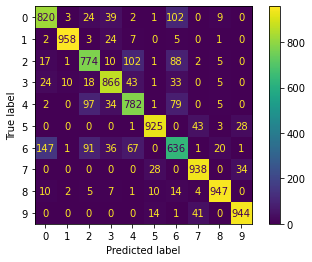

In [30]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

We can see that the model confuses category 0 and 6, 2 and 6, 2 and 4, 4 and 6. Let's see what they correspond to.

In [32]:
for i in range(len(labels)):
    print(f'Category {i} is : {labels[i]}')

Category 0 is : T-shirt/top
Category 1 is : Trouser
Category 2 is : Pullover
Category 3 is : Dress
Category 4 is : Coat
Category 5 is : Sandal
Category 6 is : Shirt
Category 7 is : Sneaker
Category 8 is : Bag
Category 9 is : Ankle boot


### Model confuses :

- T-shirt/top with Shirt
- Pullover and Shirt
- Pullover and Coat
- Coat and Shirt

This makes sense, let's look at some misclassified items.

### Misclassified items 

Let's look at some misclassified items.

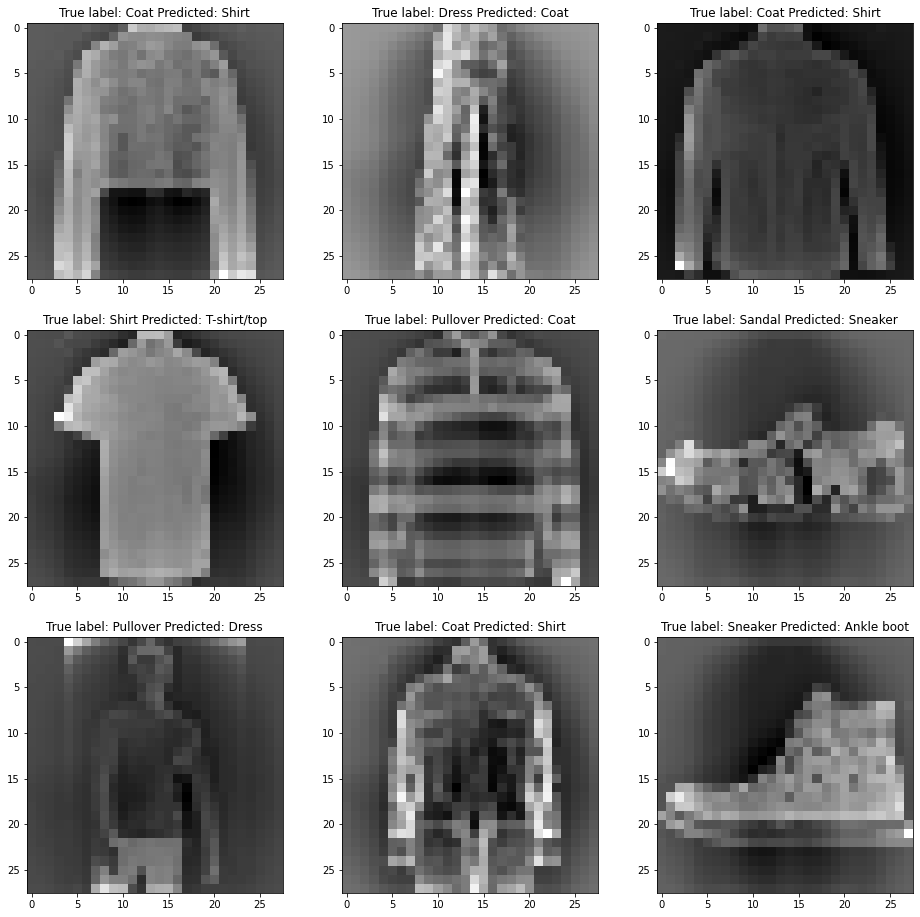

In [40]:
# img to display
img = X_test.reshape(-1,28,28)
# Show some misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
figure = plt.figure(figsize=(16,16))
cols, rows = 3, 3
for k in range(1, cols*rows+1):
    i = np.random.choice(misclassified_idx)
    figure.add_subplot(rows, cols, k)
    plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[y_pred[i]]));
    plt.imshow(img[i], cmap='gray') 
plt.show() 